In [17]:
# from ca1 graph get subgraphs

In [1]:
from bluepy import Circuit
from scipy import sparse
import numpy as np
from bluepy.enums import Cell
import pandas as pd
import tqdm
import matplotlib.pyplot as plt

In [2]:
circuitconfig_path = '/gpfs/bbp.cscs.ch/project/proj112/circuits/CA1/20211110-BioM/CircuitConfig'
ca1_synaptome_path = '/gpfs/bbp.cscs.ch/project/proj112/circuits/CA1/20211110-BioM/data/ca1_synaptome.npz'
sc_synaptome_path = '/gpfs/bbp.cscs.ch/project/proj112/circuits/CA1/20211110-BioM/data/ca3_synaptome.npz'

In [3]:
ca1_synaptome = sparse.load_npz(ca1_synaptome_path)

In [4]:
ca1_connectome = ca1_synaptome.copy()
ca1_connectome[ca1_connectome>1] = 1

In [5]:
c = Circuit(circuitconfig_path)
SC = c.projection('SC')

ImportError: cannot import name 'EdgeStorage' from 'bluepysnap.edges' (/gpfs/bbp.cscs.ch/home/kurban/venv2022/lib/python3.8/site-packages/bluepysnap/edges/__init__.py)

In [ ]:
slices = [f'slice{np.round(i).astype(int)}' for i in np.linspace(1,45,10)]

In [6]:
{i:c.cells.count(i) for i in slices}

{'slice1': 5425,
 'slice6': 11555,
 'slice11': 12470,
 'slice16': 14834,
 'slice21': 13489,
 'slice25': 12021,
 'slice30': 8929,
 'slice35': 9211,
 'slice40': 5316,
 'slice45': 972}

## Generate Slice to Slice (46x46) adj matrix based on connections between them

In [ ]:
# get slice to slice adj matrix
target_names = [i for i in c.cells.targets if i.startswith('slice') and not i.endswith('um')] # To be modified for different targets
slice2slice_adj = np.zeros((len(target_names), len(target_names)))
# create a dataframe to store the data
slice2slice_df = pd.DataFrame(index=target_names, columns=target_names)
slice2slice_df_density = pd.DataFrame(index=target_names, columns=target_names)

In [8]:
# we need to keep track of provincial hubs in each slice (compute separately) and connector hubs

##  mtype wise matrix based on normalized degree.

i.e. PC to PVBC 100 connections in slice10 out of 1000 possible connections. so its edge/max_possible_edges

In [ ]:
def normalize_synaptome(adj_orig):
    # adj = adj.tocoo()
    adj=adj_orig.copy()
    adj.data = adj.data / adj.data.sum()
    return adj

In [ ]:
mtypes = c.cells.mtypes
adj_of_interest = normalize_synaptome(ca1_synaptome)

In [11]:
adj_of_interest.max()

1.303498629304189e-07

In [12]:
adj_of_interest.sum()

0.9999999999999992

In [ ]:
# check if c is bluepy.Circuit
def is_bluepy_circuit(c):
    from bluepy import Circuit as bpyCircuit
    return isinstance(c, bpyCircuit)

def is_bluepysnap_circuit(c):
    from bluepysnap import Circuit as bpsCircuit
    return isinstance(c, bpsCircuit)

In [12]:
ca1_synaptome.max()

107.0

In [102]:
mtypes = list(mtypes)
# incorporate tqdm for target_names

for target in tqdm.tqdm(target_names): # for each target
    mt2mt_df = pd.DataFrame(index=mtypes, columns=mtypes)

    target_ids = c.cells.ids(target) -1
    target_synaptome = ca1_synaptome[target_ids, :]
    target_synaptome = target_synaptome[:, target_ids]
    
    # target_synaptome_norm = normalize_synaptome(target_synaptome)
    # print('normalized synaptome shape and sum:',target_synaptome.shape, target_synaptome.sum())

    for mt1 in mtypes:
        for mt2 in mtypes:
            # intersect target names with mtype
            if is_bluepy_circuit(c):
                mt1_indices_in_target = np.intersect1d(c.cells.ids(mt1) - 1,c.cells.ids(target) -1)
                mt2_indices_in_target = np.intersect1d(c.cells.ids(mt2) - 1,c.cells.ids(target) -1)

            elif is_bluepysnap_circuit(c):
                raise NotImplementedError
                #popname = 'hippocampus_neurons'
                #mt_indices_in_target = np.intersect1d(c.nodes[popname].ids(Cell(mt1)),c.nodes[popname].ids(Cell(target)))
            
            # index adj_of_interest with mt_indices_in_target
            mt1_to_mt2 = ca1_synaptome[mt1_indices_in_target, :]
            mt1_to_mt2 = mt1_to_mt2[:, mt2_indices_in_target]

            mt1_to_mt2_norm = mt1_to_mt2 / target_synaptome.data.sum() # normalized by the sum of that target's synapses
            
            mt2mt_df.loc[mt1,mt2] = mt1_to_mt2_norm.sum()
 
            # print(f'{mt1} to {mt2} in {target} has edge weight {mt1_to_mt2_norm.sum()} (within target edge proportion)')
    break
    

SP_CCKBC to SP_CCKBC in slice41 has edge weight 0.0005797997178258036 (within target edge proportion)
SP_CCKBC to SP_Ivy in slice41 has edge weight 0.00421011101701971 (within target edge proportion)
SP_CCKBC to SO_BS in slice41 has edge weight 1.1250964770229049e-05 (within target edge proportion)


/gpfs/bbp.cscs.ch/project/proj112/home/kurban/topology_paper/ipykernel_289338/119362403.py:30: RuntimeWarning: invalid value encountered in scalar divide
  density = mt1_to_mt2_norm.sum() / mt1_to_mt2_norm.size


SP_CCKBC to SLM_PPA in slice41 has edge weight 0.0 (within target edge proportion)
SP_CCKBC to SP_PC in slice41 has edge weight 0.16503158895875275 (within target edge proportion)
SP_CCKBC to SO_Tri in slice41 has edge weight 0.0001967043673995045 (within target edge proportion)
SP_CCKBC to SO_BP in slice41 has edge weight 2.7939895846068803e-05 (within target edge proportion)
SP_CCKBC to SP_PVBC in slice41 has edge weight 0.004559078440976315 (within target edge proportion)
SP_CCKBC to SO_OLM in slice41 has edge weight 0.0003142769492483981 (within target edge proportion)
SP_CCKBC to SP_AA in slice41 has edge weight 0.0003724069338945815 (within target edge proportion)
SP_CCKBC to SR_SCA in slice41 has edge weight 5.1941954022557435e-05 (within target edge proportion)
SP_CCKBC to SP_BS in slice41 has edge weight 0.0021954382588306957 (within target edge proportion)
SP_Ivy to SP_CCKBC in slice41 has edge weight 0.0016820192331492428 (within target edge proportion)
SP_Ivy to SP_Ivy in s

/gpfs/bbp.cscs.ch/project/proj112/home/kurban/topology_paper/ipykernel_289338/119362403.py:30: RuntimeWarning: invalid value encountered in scalar divide
  density = mt1_to_mt2_norm.sum() / mt1_to_mt2_norm.size


SO_BS to SLM_PPA in slice41 has edge weight 0.0 (within target edge proportion)
SO_BS to SP_PC in slice41 has edge weight 0.0049575501099219255 (within target edge proportion)
SO_BS to SO_Tri in slice41 has edge weight 8.438223577671785e-06 (within target edge proportion)
SO_BS to SO_BP in slice41 has edge weight 3.937837669580167e-06 (within target edge proportion)
SO_BS to SP_PVBC in slice41 has edge weight 0.00028521195692530636 (within target edge proportion)
SO_BS to SO_OLM in slice41 has edge weight 3.487799078771005e-05 (within target edge proportion)
SO_BS to SP_AA in slice41 has edge weight 2.9627540561603163e-05 (within target edge proportion)
SO_BS to SR_SCA in slice41 has edge weight 4.50038590809162e-06 (within target edge proportion)
SO_BS to SP_BS in slice41 has edge weight 9.432058799042018e-05 (within target edge proportion)
SLM_PPA to SP_CCKBC in slice41 has edge weight 9.825842566000035e-05 (within target edge proportion)
SLM_PPA to SP_Ivy in slice41 has edge weight 

/gpfs/bbp.cscs.ch/project/proj112/home/kurban/topology_paper/ipykernel_289338/119362403.py:30: RuntimeWarning: invalid value encountered in scalar divide
  density = mt1_to_mt2_norm.sum() / mt1_to_mt2_norm.size


SLM_PPA to SO_BS in slice41 has edge weight 0.0 (within target edge proportion)
SLM_PPA to SLM_PPA in slice41 has edge weight 1.8751607950381745e-05 (within target edge proportion)
SLM_PPA to SP_PC in slice41 has edge weight 0.005548038244279447 (within target edge proportion)
SLM_PPA to SO_Tri in slice41 has edge weight 5.625482385114524e-07 (within target edge proportion)
SLM_PPA to SO_BP in slice41 has edge weight 1.8751607950381747e-07 (within target edge proportion)
SLM_PPA to SP_PVBC in slice41 has edge weight 0.00020120475330759617 (within target edge proportion)


/gpfs/bbp.cscs.ch/project/proj112/home/kurban/topology_paper/ipykernel_289338/119362403.py:30: RuntimeWarning: invalid value encountered in scalar divide
  density = mt1_to_mt2_norm.sum() / mt1_to_mt2_norm.size


SLM_PPA to SO_OLM in slice41 has edge weight 0.0 (within target edge proportion)
SLM_PPA to SP_AA in slice41 has edge weight 4.8754180670992545e-05 (within target edge proportion)
SLM_PPA to SR_SCA in slice41 has edge weight 3.0002572720610794e-06 (within target edge proportion)
SLM_PPA to SP_BS in slice41 has edge weight 3.187773351564897e-06 (within target edge proportion)
SP_PC to SP_CCKBC in slice41 has edge weight 0.010189436244157937 (within target edge proportion)
SP_PC to SP_Ivy in slice41 has edge weight 0.045469086474165164 (within target edge proportion)
SP_PC to SO_BS in slice41 has edge weight 0.00425830264945219 (within target edge proportion)


/gpfs/bbp.cscs.ch/project/proj112/home/kurban/topology_paper/ipykernel_289338/119362403.py:30: RuntimeWarning: invalid value encountered in scalar divide
  density = mt1_to_mt2_norm.sum() / mt1_to_mt2_norm.size


SP_PC to SLM_PPA in slice41 has edge weight 0.0 (within target edge proportion)
SP_PC to SP_PC in slice41 has edge weight 0.11900632979277961 (within target edge proportion)
SP_PC to SO_Tri in slice41 has edge weight 0.004837914851198491 (within target edge proportion)
SP_PC to SO_BP in slice41 has edge weight 0.0008807630254294306 (within target edge proportion)
SP_PC to SP_PVBC in slice41 has edge weight 0.051998021330329075 (within target edge proportion)
SP_PC to SO_OLM in slice41 has edge weight 0.010729857585287939 (within target edge proportion)
SP_PC to SP_AA in slice41 has edge weight 0.008635678009389306 (within target edge proportion)
SP_PC to SR_SCA in slice41 has edge weight 0.0007832546640874456 (within target edge proportion)
SP_PC to SP_BS in slice41 has edge weight 0.014643130648453106 (within target edge proportion)
SO_Tri to SP_CCKBC in slice41 has edge weight 6.713075646236665e-05 (within target edge proportion)
SO_Tri to SP_Ivy in slice41 has edge weight 0.00039697

/gpfs/bbp.cscs.ch/project/proj112/home/kurban/topology_paper/ipykernel_289338/119362403.py:30: RuntimeWarning: invalid value encountered in scalar divide
  density = mt1_to_mt2_norm.sum() / mt1_to_mt2_norm.size


SO_Tri to SLM_PPA in slice41 has edge weight 0.0 (within target edge proportion)
SO_Tri to SP_PC in slice41 has edge weight 0.010094740624008513 (within target edge proportion)
SO_Tri to SO_Tri in slice41 has edge weight 2.4377090335496276e-05 (within target edge proportion)
SO_Tri to SO_BP in slice41 has edge weight 3.187773351564897e-06 (within target edge proportion)
SO_Tri to SP_PVBC in slice41 has edge weight 0.0004620396198974061 (within target edge proportion)
SO_Tri to SO_OLM in slice41 has edge weight 0.00011663500145137446 (within target edge proportion)
SO_Tri to SP_AA in slice41 has edge weight 5.888004896419869e-05 (within target edge proportion)
SO_Tri to SR_SCA in slice41 has edge weight 6.563062782633613e-06 (within target edge proportion)
SO_Tri to SP_BS in slice41 has edge weight 0.000169514535871451 (within target edge proportion)
SO_BP to SP_CCKBC in slice41 has edge weight 2.3439509937977187e-05 (within target edge proportion)
SO_BP to SP_Ivy in slice41 has edge we

/gpfs/bbp.cscs.ch/project/proj112/home/kurban/topology_paper/ipykernel_289338/119362403.py:30: RuntimeWarning: invalid value encountered in scalar divide
  density = mt1_to_mt2_norm.sum() / mt1_to_mt2_norm.size


SP_AA to SP_CCKBC in slice41 has edge weight 0.0 (within target edge proportion)


/gpfs/bbp.cscs.ch/project/proj112/home/kurban/topology_paper/ipykernel_289338/119362403.py:30: RuntimeWarning: invalid value encountered in scalar divide
  density = mt1_to_mt2_norm.sum() / mt1_to_mt2_norm.size


SP_AA to SP_Ivy in slice41 has edge weight 0.0 (within target edge proportion)


/gpfs/bbp.cscs.ch/project/proj112/home/kurban/topology_paper/ipykernel_289338/119362403.py:30: RuntimeWarning: invalid value encountered in scalar divide
  density = mt1_to_mt2_norm.sum() / mt1_to_mt2_norm.size


SP_AA to SO_BS in slice41 has edge weight 0.0 (within target edge proportion)


/gpfs/bbp.cscs.ch/project/proj112/home/kurban/topology_paper/ipykernel_289338/119362403.py:30: RuntimeWarning: invalid value encountered in scalar divide
  density = mt1_to_mt2_norm.sum() / mt1_to_mt2_norm.size


SP_AA to SLM_PPA in slice41 has edge weight 0.0 (within target edge proportion)
SP_AA to SP_PC in slice41 has edge weight 0.008122258983707852 (within target edge proportion)


/gpfs/bbp.cscs.ch/project/proj112/home/kurban/topology_paper/ipykernel_289338/119362403.py:30: RuntimeWarning: invalid value encountered in scalar divide
  density = mt1_to_mt2_norm.sum() / mt1_to_mt2_norm.size


SP_AA to SO_Tri in slice41 has edge weight 0.0 (within target edge proportion)


/gpfs/bbp.cscs.ch/project/proj112/home/kurban/topology_paper/ipykernel_289338/119362403.py:30: RuntimeWarning: invalid value encountered in scalar divide
  density = mt1_to_mt2_norm.sum() / mt1_to_mt2_norm.size


SP_AA to SO_BP in slice41 has edge weight 0.0 (within target edge proportion)


/gpfs/bbp.cscs.ch/project/proj112/home/kurban/topology_paper/ipykernel_289338/119362403.py:30: RuntimeWarning: invalid value encountered in scalar divide
  density = mt1_to_mt2_norm.sum() / mt1_to_mt2_norm.size


SP_AA to SP_PVBC in slice41 has edge weight 0.0 (within target edge proportion)


/gpfs/bbp.cscs.ch/project/proj112/home/kurban/topology_paper/ipykernel_289338/119362403.py:30: RuntimeWarning: invalid value encountered in scalar divide
  density = mt1_to_mt2_norm.sum() / mt1_to_mt2_norm.size


SP_AA to SO_OLM in slice41 has edge weight 0.0 (within target edge proportion)


/gpfs/bbp.cscs.ch/project/proj112/home/kurban/topology_paper/ipykernel_289338/119362403.py:30: RuntimeWarning: invalid value encountered in scalar divide
  density = mt1_to_mt2_norm.sum() / mt1_to_mt2_norm.size


SP_AA to SP_AA in slice41 has edge weight 0.0 (within target edge proportion)


/gpfs/bbp.cscs.ch/project/proj112/home/kurban/topology_paper/ipykernel_289338/119362403.py:30: RuntimeWarning: invalid value encountered in scalar divide
  density = mt1_to_mt2_norm.sum() / mt1_to_mt2_norm.size


SP_AA to SR_SCA in slice41 has edge weight 0.0 (within target edge proportion)


/gpfs/bbp.cscs.ch/project/proj112/home/kurban/topology_paper/ipykernel_289338/119362403.py:30: RuntimeWarning: invalid value encountered in scalar divide
  density = mt1_to_mt2_norm.sum() / mt1_to_mt2_norm.size


SP_AA to SP_BS in slice41 has edge weight 0.0 (within target edge proportion)
SR_SCA to SP_CCKBC in slice41 has edge weight 2.981505664110698e-05 (within target edge proportion)
SR_SCA to SP_Ivy in slice41 has edge weight 9.37580397519087e-05 (within target edge proportion)
SR_SCA to SO_BS in slice41 has edge weight 1.8751607950381748e-06 (within target edge proportion)
SR_SCA to SLM_PPA in slice41 has edge weight 1.8751607950381745e-06 (within target edge proportion)
SR_SCA to SP_PC in slice41 has edge weight 0.004332371500856202 (within target edge proportion)
SR_SCA to SO_Tri in slice41 has edge weight 2.812741192557262e-06 (within target edge proportion)
SR_SCA to SO_BP in slice41 has edge weight 1.125096477022905e-06 (within target edge proportion)
SR_SCA to SP_PVBC in slice41 has edge weight 0.00010332135980660343 (within target edge proportion)
SR_SCA to SO_OLM in slice41 has edge weight 1.031338437270996e-05 (within target edge proportion)
SR_SCA to SP_AA in slice41 has edge we

In [161]:
# create a multiindex dataframe to store the data from mtype to mtype for each target
df_mt_for_all_slices = pd.DataFrame(index=pd.MultiIndex.from_product([mtypes, mtypes], names=['pre', 'post']), columns=target_names)
# get sp_pc to sp_pc on slice 30


for target in tqdm.tqdm(target_names): # for each target
    mt2mt_df = pd.DataFrame(index=mtypes, columns=mtypes)

    target_ids = c.cells.ids(target) -1
    target_synaptome = ca1_synaptome[target_ids, :]
    target_synaptome = target_synaptome[:, target_ids]
    
    # target_synaptome_norm = normalize_synaptome(target_synaptome)
    # print('normalized synaptome shape and sum:',target_synaptome.shape, target_synaptome.sum())

    for mt1 in mtypes:
        for mt2 in mtypes:
            if is_bluepy_circuit(c):
                mt1_indices_in_target = np.intersect1d(c.cells.ids(mt1) - 1,c.cells.ids(target) -1)
                mt2_indices_in_target = np.intersect1d(c.cells.ids(mt2) - 1,c.cells.ids(target) -1)

            elif is_bluepysnap_circuit(c):
                raise NotImplementedError
                #popname = 'hippocampus_neurons'
                #mt_indices_in_target = np.intersect1d(c.nodes[popname].ids(Cell(mt1)),c.nodes[popname].ids(Cell(target)))
            
            # index adj_of_interest with mt_indices_in_target
            mt1_to_mt2 = ca1_synaptome[mt1_indices_in_target, :]
            mt1_to_mt2 = mt1_to_mt2[:, mt2_indices_in_target]

            mt1_to_mt2_norm = mt1_to_mt2 / target_synaptome.data.sum() # normalized by the sum of that target's synapses
            
            # mt2mt_df.loc[mt1,mt2] = mt1_to_mt2_norm.sum()
            df_mt_for_all_slices.loc[(mt1, mt2), target] = mt1_to_mt2_norm.sum()

 

100%|██████████| 47/47 [1:24:49<00:00, 108.28s/it]


In [162]:
df_mt_for_all_slices.to_csv('df_mt_for_all_slices.csv')

In [ ]:
df_mt_for_all_slices = pd.read_csv('df_mt_for_all_slices.csv',index_col=[0,1])

In [15]:
np.testing.assert_array_almost_equal(mt2mt_df.sum().sum(),1)

NameError: name 'mt2mt_df' is not defined

In [16]:
df_mt_for_all_slices.head()

slice41   slice29   slice31       slice32   slice45  \
pre      post                                                             
SP_CCKBC SP_CCKBC  0.000580  0.000386  0.000518  6.074139e-04  0.000038   
         SP_Ivy    0.004210  0.003985  0.003584  4.455216e-03  0.001857   
         SO_BS     0.000011  0.000003  0.000071  4.880295e-05  0.000000   
         SLM_PPA   0.000000  0.000000  0.000000  7.948363e-08  0.000000   
         SP_PC     0.165032  0.144862  0.149641  1.632510e-01  0.052224   

                        slice11       slice35       slice17       slice15  \
pre      post                                                               
SP_CCKBC SP_CCKBC  5.594070e-04  5.581348e-04  5.411007e-04  5.914604e-04   
         SP_Ivy    4.129694e-03  4.181362e-03  4.298637e-03  4.540306e-03   
         SO_BS     7.832543e-05  1.467204e-05  3.177587e-05  6.902413e-05   
         SLM_PPA   1.408731e-07  8.530258e-08  4.286795e-07  5.834669e-07   
         SP_PC     1.633252e-01  1.488730e-01  1.479361e-01  1.614413e-01   

                    slice28  ...    slice2   slice24   slice21   slice30  \
pre      post                ...                                           
SP_CCKBC SP_CCKBC  0.000495  ...  0.000372  0.000482  0.000487  0.000702   
         SP_Ivy    0.004053  ...  0.003637  0.004003  0.003922  0.004839   
         SO_BS     0.000013  ...  0.000035  0.000020  0.000050  0.000037   
         SLM_PPA   0.000000  ...  0.000000  0.000000  0.000000  0.000000   
         SP_PC     0.157452  ...  0.128168  0.152388  0.145936  0.181058   

                        slice39   slice38       slice43   slice25  \
pre      post                                                       
SP_CCKBC SP_CCKBC  6.849817e-04  0.000615  4.148069e-04  0.000552   
         SP_Ivy    5.045276e-03  0.004451  3.991868e-03  0.003838   
         SO_BS     1.796376e-05  0.000057  7.509670e-05  0.000032   
         SLM_PPA   1.814521e-07  0.000000  2.730789e-07  0.000000   
         SP_PC     1.721629e-01  0.159972  1.431876e-01  0.161377   

                        slice12        slice5  
pre      post                                  
SP_CCKBC SP_CCKBC  5.930059e-04  6.653254e-04  
         SP_Ivy    4.620112e-03  4.645564e-03  
         SO_BS     7.659830e-05  7.395134e-05  
         SLM_PPA   6.820864e-08  8.282550e-07  
         SP_PC     1.674994e-01  1.697145e-01  

[5 rows x 47 columns]

In [6]:
slice10_df = df_mt_for_all_slices.loc[:,'slice10'].copy().reset_index()
slice10_df

NameError: name 'df_mt_for_all_slices' is not defined

In [71]:
test = df_mt_for_all_slices.loc[:,'slice10'].copy()
test

pre       post    
SP_CCKBC  SP_CCKBC    5.282538e-04
          SP_Ivy      4.163596e-03
          SO_BS       6.699201e-05
          SLM_PPA     6.510399e-08
          SP_PC       1.554774e-01
                          ...     
SP_BS     SP_PVBC     3.270304e-03
          SO_OLM      1.970698e-04
          SP_AA       2.033849e-04
          SR_SCA      4.947903e-05
          SP_BS       1.083916e-03
Name: slice10, Length: 144, dtype: float64

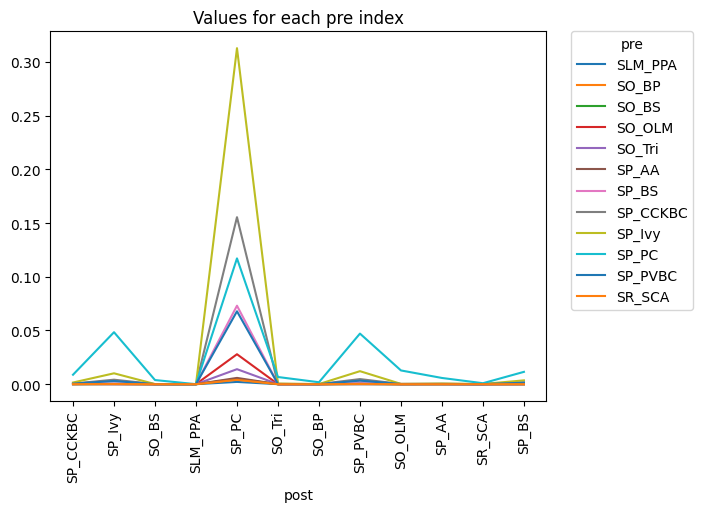

In [98]:
# Group the DataFrame by 'pre' index level
test = df_mt_for_all_slices.loc[:,'slice10'].copy()
grouped = test.groupby('pre')

# Create separate plots for each group
for pre, group in grouped:
    plt.plot(group.index.get_level_values('post'), group.values, label=pre)

# Set plot title, x-axis label, and legend
plt.title('Values for each pre index')
plt.xlabel('post')
plt.legend(title='pre',bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
xlabels = group.index.get_level_values('post')
plt.xticks(range(len(xlabels)), xlabels, rotation=90)

# Display the plots
plt.show()

In [17]:
def plot_degree2(base_df,target,kind):
    
    if kind == 'in':
        sel_group = 'pre'
        other_group = 'post'
    elif kind == 'out':
        sel_group = 'post'
        other_group = 'pre'
    else:
        raise NotImplementedError

    target_df = base_df.loc[:,target].copy()
    grouped = target_df.groupby(sel_group)

    # Create separate plots for each group
    for sel_group, group in grouped:
        plt.plot(group.index.get_level_values(other_group), group.values, label=sel_group)

    # Set plot title, x-axis label, and legend
    plt.title(f'{kind}degree')
    plt.xlabel(other_group)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    xlabels = group.index.get_level_values(other_group)
    plt.xticks(range(len(xlabels)), xlabels, rotation=90)

    # Display the plots
    plt.show()

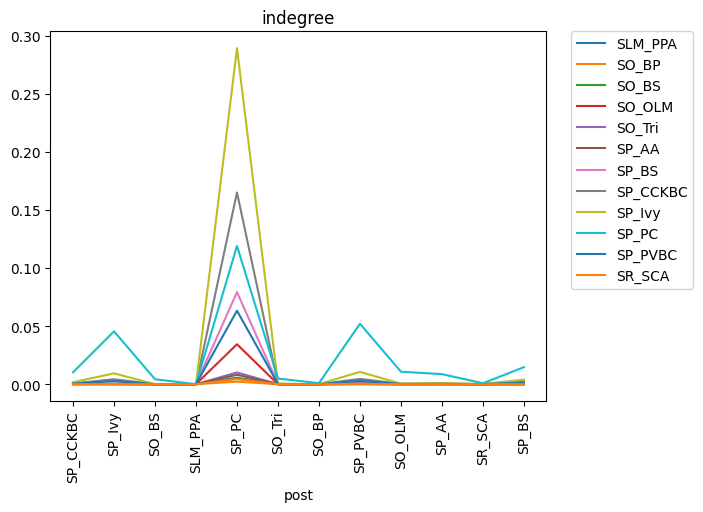

In [108]:
plot_degree2(df_mt_for_all_slices,'slice41','in')

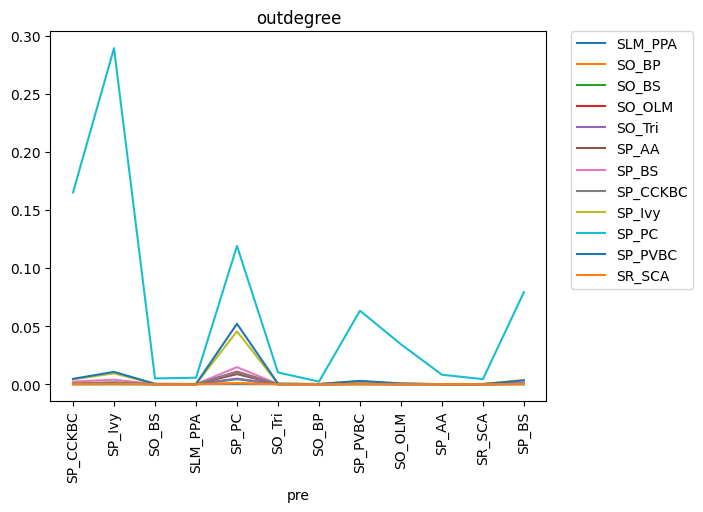

In [109]:
plot_degree2(df_mt_for_all_slices,'slice41','out')

In [39]:
slice10_pivot = slice10_df.pivot(index='pre',columns='post')

In [41]:
target='slice10'

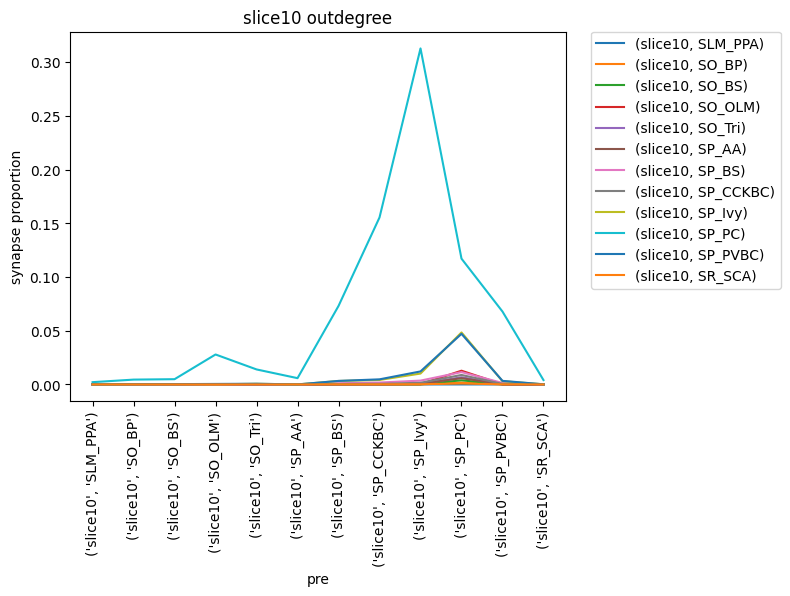

In [42]:
# horizontally plot
slice10_pivot.plot()
# get all xlabels
xlabels = slice10_pivot.columns
# get all ylabels
# set these labals as the ticklabels
plt.xticks(range(len(xlabels)), xlabels, rotation=90)
# put legend outside
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.ylabel('synapse proportion')
plt.title(f'{target} outdegree')

plt.show()

In [59]:
def plot_degree(base_df,target,kind):
    
    try:
        target_df = base_df.loc[:,target].copy().reset_index()
    except Exception as e:
        print(f'Error loading {target}. {str(e)}')
    target_df_pivot = target_df.pivot(index='pre',columns='post')
    
    if kind=='in':
        target_df = target_df.T
    elif kind=='out':
        pass
    else:
        raise NotImplementedError
        
    # horizontally plot
    target_df_pivot.plot()
    # get all xlabels
    xlabels = target_df_pivot.columns
    # get all ylabels
    # set these labals as the ticklabels
    plt.xticks(range(len(xlabels)), xlabels, rotation=90)
    # put legend outside
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.ylabel('synapse proportion')
    plt.title(f'{target} {kind}degree')

    plt.show()

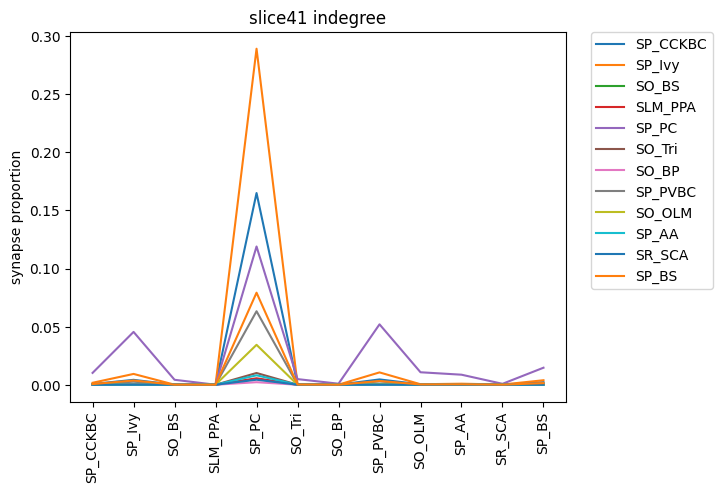

In [116]:
mt2mt_df.T.plot()
# get all xlabels
xlabels = mt2mt_df.columns
# get all ylabels
# set these labals as the ticklabels
plt.xticks(range(len(xlabels)), xlabels, rotation=90)
# put legend outside
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.ylabel('synapse proportion')
plt.title(f'{target} indegree')
plt.show()

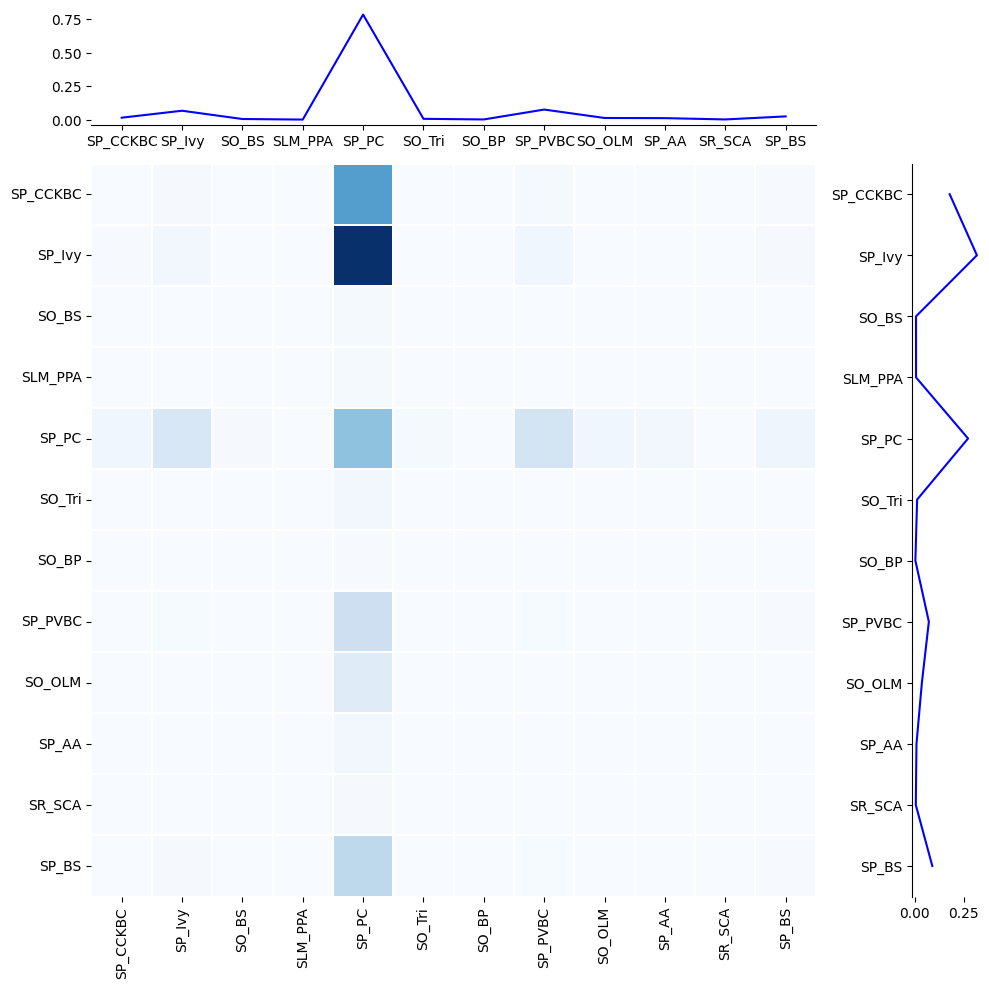

In [146]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define your desired figure size
fig_size = (10, 10)

# Create a jointplot with a heatmap in the middle
joint_grid = sns.JointGrid(x=range(df.shape[1]), y=range(df.shape[0]), data=df, height=fig_size[0])

# Create the heatmap
sns.heatmap(df, ax=joint_grid.ax_joint, cbar=False,linecolor='white',linewidths=0.1, cmap='Blues')

# Clear the marginal plots that jointplot creates by default
joint_grid.ax_marg_x.cla()
joint_grid.ax_marg_y.cla()

# Plot the line plot on the x marginal with a 0.5 shift
joint_grid.ax_marg_x.plot(np.arange(df.shape[1])+0.5, df.sum(), color='blue')

# Plot the line plot on the y marginal (with horizontal orientation) with a 0.5 shift
joint_grid.ax_marg_y.plot(df.T.sum(), np.arange(df.shape[0])+0.5, 'b')

# Set the tick labels
joint_grid.ax_joint.set_xticks(np.arange(df.shape[1])+0.5)
joint_grid.ax_joint.set_yticks(np.arange(df.shape[0])+0.5)
joint_grid.ax_joint.set_xticklabels(df.columns, rotation=90)
joint_grid.ax_joint.set_yticklabels(df.columns, rotation=0)


# Adjust plot margins
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.tight_layout()
# Show the plot
plt.show()


In [7]:
{i:c.cells.count(i) for i in c.cells.targets if i.endswith('r300') and i.startswith('cylinder')}

{'cylinder397485r300': 7293,
 'cylinder299049r300': 7733,
 'cylinder128660r300': 5461,
 'cylinder253803r300': 6532,
 'cylinder300': 6213,
 'cylinder216679r300': 7716,
 'cylinder329179r300': 7934,
 'cylinder109262r300': 7302,
 'cylinder297714r300': 6397,
 'cylinder269358r300': 6360}

In [32]:
from coordinate_query import CoordinateQuery, query_enriched_positions, LON, TRA, RAD,enriched_cells_positions
from log_progress import log_progress
from pathlib import Path
from voxcell.nexus.voxelbrain import Atlas


In [29]:
ATLAS_DIR = Path("/gpfs/bbp.cscs.ch/project/proj112/entities/atlas/20211004_BioM/")
atlas = Atlas.open(ATLAS_DIR.as_posix())
orientation = atlas.load_data("orientation")

In [34]:
# load the atlas in the coordinatequery
file_path = '/gpfs/bbp.cscs.ch/project/proj112/entities/atlas/20211004_BioM/coordinates.nrrd'
q = CoordinateQuery(file_path)
# Enriched your ltr positions in the positions df from bluepy
xyz_ltr = enriched_cells_positions(c, q)

In [35]:
slice_thickness = 400 # um

print(f"slice thickness: {slice_thickness}")
slice_id = 1
for l in log_progress(range(0, int(q.get_long_center_distance(q.min_max[LON][0], q.min_max[LON][1])), slice_thickness), every=1):
    l_min, l_max = q.long_micro_meter_slice(l, slice_thickness) # relative coordinate
    percentage = (l_min + l_max)/2
    print(f"l:{l}, l_min:{l_min}, l_max:{l_max}, percentage={percentage}")
    cur_slice_mask = q._get_range_mask(min_value=l_min, max_value=l_max, axis=LON)
    #orientation.with_data(np.asarray(cur_slice_mask, dtype=np.uint8)).save_nrrd(f"nrrd_masks_serially_generated_but_not_used/slice{slice_thickness}_{slice_id}.nrrd")
    #slice_id += 1
    break

slice thickness: 400


l:0, l_min:0.043989644635413404, l_max:0.07021988810231852, percentage=0.05710476636886597


In [37]:
q.ltr_range_to_xyz(lon_min=0.2, lon_max=0.3, tra_min=0.4, tra_max=0.6, rad_min=0.4, rad_max=0.6)

array([[2161.45999908,  599.83999634, 5016.        ],
       [2161.45999908,  631.83999634, 5048.        ],
       [2161.45999908,  647.83999634, 5032.        ],
       ...,
       [3025.45999908,  679.83999634, 3800.        ],
       [3041.45999908,  663.83999634, 3800.        ],
       [3041.45999908,  679.83999634, 3784.        ]])

In [50]:
## LTR Cube

l_iso = q.ltr_iso_to_idx(0.5,0.1,LON)
t_iso = q.ltr_iso_to_idx(0.5,0.1,TRA)
r_iso = q.ltr_iso_to_idx(0.5,0.1,RAD)

# Find the common values along the rows (axis=0)
common_rows = np.intersect1d(np.intersect1d(l_iso[:, 0], t_iso[:, 0]), r_iso[:, 0])

# Filter the common rows from the original arrays
common_values = l_iso[np.isin(l_iso[:, 0], common_rows)]
common_values = common_values[np.isin(common_values[:, 1], common_rows)]
common_values = common_values[np.isin(common_values[:, 2], common_rows)]

# TODO: Validate with visualization


In [52]:
common_values.shape # check if this is a cube indeed . but volumevise, its not what we want. also dimension vise

(50492, 3)

In [57]:
# we want to get a cube with x_start,x_end and for y, and z.
# dx , dy, dz is given in the experiment
dx,dy,dz = 100, 100, 100 # um
# get the x_start from ltr where we are in SP
sp = atlas.get_region_mask("SP")

In [60]:
np.unique(sp.raw,return_counts=True)

(array([False,  True]), array([70355955,   385485]))

In [64]:
np.where(sp.raw)

(array([ 56,  56,  56, ..., 296, 296, 296]),
 array([ 93,  94,  94, ..., 159, 160, 160]),
 array([390, 390, 391, ...,  79,  78,  79]))

In [72]:
# get l= 0.1-0.3 T=0.4-0.6 R=0-1
l_iso = q.ltr_iso_to_idx(0.2,0.1,LON)
t_iso = q.ltr_iso_to_idx(0.5,0.1,TRA)
r_iso = q.ltr_iso_to_idx(0,1,RAD)

# Find the common values along the rows (axis=0)
common_rows = np.intersect1d(np.intersect1d(l_iso[:, 0], t_iso[:, 0]), r_iso[:, 0])

# Filter the common rows from the original arrays
common_values = l_iso[np.isin(l_iso[:, 0], common_rows)]
common_values = common_values[np.isin(common_values[:, 1], common_rows)]
common_values = common_values[np.isin(common_values[:, 2], common_rows)]

print(common_values.shape)
# get sp mask indices
sp = atlas.get_region_mask("SP")
sp_indices = np.column_stack(np.where(sp.raw))

# get intersection

(20167, 3)


In [80]:
common_values.shape

(20167, 3)

In [81]:
sp_indices.shape

(385485, 3)

In [82]:
sp_only = matrix1[np.all(np.isin(matrix1, matrix2), axis=1)]


TypeError: intersect1d() got an unexpected keyword argument 'axis'

In [56]:
!ls /gpfs/bbp.cscs.ch/project/proj112/entities/atlas/20211004_BioM/

brain_regions.nrrd	  cylinders	   nrrd_volumes      README.md
CA1			  dev		   orientation.nrrd  README.md~
ca1_metadata.json	  flatmap	   [PH]SLM.nrrd      shell
cell_density_files	  flatmap_lt.nrrd  [PH]SO.nrrd	     slices
[cell_density]SP_PC.nrrd  flatmap_r.nrrd   [PH]SP.nrrd	     SLM_PPA.nrrd
coordinates.nrrd	  hierarchy.json   [PH]SR.nrrd	     SR_SCA.nrrd
cylinder300.nrrd	  logs		   [PH]y.nrrd
cylinder300_raw.nrrd	  meshes	   planes


In [ ]:
l_thickness,t_thickness,r_thickness = 100,100,100
l_center, t_center, r_center = 0.25, 0.5 , 0.5
l_min, l_max = q.long_micro_meter_slice(l_center, l_thickness) # relative coordinate

In [ ]:
# EM targets as cube

l,t,r = 0.2 , 0.5, 0.2 # make sure to sample from SP
size = 
from utils import extract_cube(l,t,r):

In [18]:
c.cells.targets

{'100_per_mtype',
 'All',
 'BC',
 'BS',
 'CA3_SP_PC',
 'CB1R_neg',
 'CB1R_pos',
 'CCK',
 'Excitatory',
 'Inhibitory',
 'LFPCompartments',
 'Mosaic',
 'PV',
 'SC_sampled',
 'SLM',
 'SLM_PPA',
 'SO',
 'SOM',
 'SO_BP',
 'SO_BS',
 'SO_OLM',
 'SO_Tri',
 'SP',
 'SP_AA',
 'SP_BS',
 'SP_CCKBC',
 'SP_INT',
 'SP_Ivy',
 'SP_PC',
 'SP_PVBC',
 'SR',
 'SR_SCA',
 'bAC',
 'cAC',
 'cACpyr',
 'cNAC',
 'cylinder109262r300',
 'cylinder128660r300',
 'cylinder216679r300',
 'cylinder253803r300',
 'cylinder269358r300',
 'cylinder297714r300',
 'cylinder299049r300',
 'cylinder300',
 'cylinder300_exc',
 'cylinder300_inh',
 'cylinder329179r300',
 'cylinder397485r300',
 'cylinders',
 'cylinders300',
 'destination_cyl_unique',
 'destination_single',
 'nonCCK',
 'slice0',
 'slice1',
 'slice10',
 'slice11',
 'slice12',
 'slice13',
 'slice14',
 'slice15',
 'slice16',
 'slice17',
 'slice18',
 'slice19',
 'slice2',
 'slice20',
 'slice21',
 'slice22',
 'slice23',
 'slice24',
 'slice25',
 'slice26',
 'slice27',
 'slice28'

In [18]:
target = 'slice10'

In [19]:
num_target_nodes = c.cells.count(target)
target_gids = c.cells.ids(target)
target_e_gids = c.cells.get(group={Cell.MTYPE: "SP_PC", '$target': target}).index.tolist()
target_i_gids = np.setdiff1d(target_gids,target_e_gids)

In [20]:
mtypes_by_gid = np.array(c.cells.get(target).mtype.values)
df = pd.DataFrame(mtypes_by_gid,index=target_gids,columns=['mtype'])

target_data = c.cells.get(target)

In [15]:
all2target_synaptome = ca1_synaptome[:,target_gids-1] # TODO: check out-target to target connections for modularity analyses

In [16]:
all2target_synaptome

<456378x12615 sparse matrix of type '<class 'numpy.float64'>'
	with 4301424 stored elements in Compressed Sparse Column format>

# For Connectome

In [ ]:
def get_adj_mtype(df,mtypes,kind='synaptome'):
    # create a multiindex dataframe to store the data from mtype to mtype for each target
    df_mt_for_all_slices = pd.DataFrame(index=pd.MultiIndex.from_product([mtypes, mtypes], names=['pre', 'post']), columns=target_names)
    # get sp_pc to sp_pc on slice 30


    for target in tqdm.tqdm(target_names): # for each target
        mt2mt_df = pd.DataFrame(index=mtypes, columns=mtypes)

        target_ids = c.cells.ids(target) -1
        target_synaptome = ca1_synaptome[target_ids, :]
        target_synaptome = target_synaptome[:, target_ids]

        # target_synaptome_norm = normalize_synaptome(target_synaptome)
        # print('normalized synaptome shape and sum:',target_synaptome.shape, target_synaptome.sum())

        for mt1 in mtypes:
            for mt2 in mtypes:
                if is_bluepy_circuit(c):
                    mt1_indices_in_target = np.intersect1d(c.cells.ids(mt1) - 1,c.cells.ids(target) -1)
                    mt2_indices_in_target = np.intersect1d(c.cells.ids(mt2) - 1,c.cells.ids(target) -1)

                elif is_bluepysnap_circuit(c):
                    raise NotImplementedError
                    #popname = 'hippocampus_neurons'
                    #mt_indices_in_target = np.intersect1d(c.nodes[popname].ids(Cell(mt1)),c.nodes[popname].ids(Cell(target)))

                # index adj_of_interest with mt_indices_in_target
                mt1_to_mt2 = ca1_synaptome[mt1_indices_in_target, :]
                mt1_to_mt2 = mt1_to_mt2[:, mt2_indices_in_target]

                mt1_to_mt2_norm = mt1_to_mt2 / target_synaptome.data.sum() # normalized by the sum of that target's synapses

                # mt2mt_df.loc[mt1,mt2] = mt1_to_mt2_norm.sum()
                df_mt_for_all_slices.loc[(mt1, mt2), target] = mt1_to_mt2_norm.sum()

 